In [1]:
%matplotlib inline
import random
import seaborn as sns
random.seed(0)
import numpy as np
import warnings
warnings.simplefilter('ignore')
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib.legend_handler import HandlerLine2D
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve, GridSearchCV, validation_curve

In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

skips = 2
X_train=np.delete(X_train, list(range(0, X_train.shape[1], skips)), axis=1)
X_train=np.delete(X_train, list(range(0, X_train.shape[2], skips)), axis=2)
X_train = X_train.reshape(X_train.shape[0],-1)

X_test = np.delete(X_test, list(range(0, X_test.shape[1], skips)), axis=1)
X_test = np.delete(X_test, list(range(0, X_test.shape[2], skips)), axis=2)
X_test = X_test.reshape(X_test.shape[0],-1)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# pca = PCA(n_components=30)
# X_train = pca.fit_transform(X_train)
# X_test = pca.fit_transform(X_test)

idx_train = np.random.choice(60000, size = 10000, replace = False)
idx_test = np.random.choice(10000, size = 1000, replace = False)
X_train, y_train = X_train[idx_train], y_train[idx_train]
X_test, y_test = X_test[idx_test], y_test[idx_test]

Using TensorFlow backend.


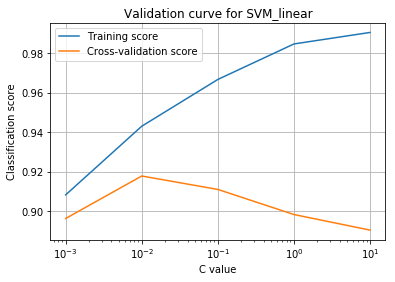

In [3]:
seed = 0
n_cv = 5

svm_linear = SVC(kernel='linear', probability=True,random_state=seed)

C_range = [0.001,0.01,0.1,1,10]
train_scores, test_scores = validation_curve(svm_linear, X_train, y_train, param_name="C", param_range=C_range, cv=n_cv, n_jobs=-1)

plt.figure()
plt.semilogx(C_range, np.mean(train_scores, axis=1), label='Training score')
plt.semilogx(C_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for SVM_linear')
plt.xlabel('C value')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
plt.show()

In [4]:
tuned_params = {'C' : C_range}
clf = GridSearchCV(svm_linear, param_grid=tuned_params, cv=n_cv, n_jobs=-1)

clf.fit(X_train, y_train)
print("Best parameters set for SVM_linear:")
print(clf.best_params_)
y_pred = clf.predict(X_test)
print('Accuracy of SVM_linear is %.2f%%' % (accuracy_score(y_test, y_pred) * 100))

Best parameters set for SVM_linear:
{'C': 0.01}
Accuracy of SVM_linear is 92.50%


In [5]:
train_sizes=np.linspace(.3, 1.0, 5)

train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv=n_cv, train_sizes=train_sizes, n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

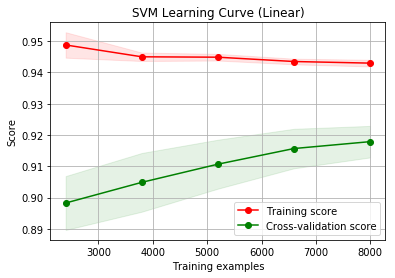

In [6]:
plt.figure()
plt.title("SVM Learning Curve (Linear)")
plt.xlabel("Training examples")
plt.ylabel("Score")

plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")

plt.show()

In [7]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       103
           1       0.96      0.99      0.97       108
           2       0.94      0.89      0.92        91
           3       0.86      0.89      0.87        79
           4       0.89      0.95      0.92        96
           5       0.88      0.88      0.88        95
           6       0.95      0.97      0.96       111
           7       0.95      0.93      0.94       109
           8       0.92      0.86      0.89       101
           9       0.94      0.89      0.91       107

   micro avg       0.93      0.93      0.93      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.93      0.93      0.92      1000



In [8]:
# https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(15,15)):
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)

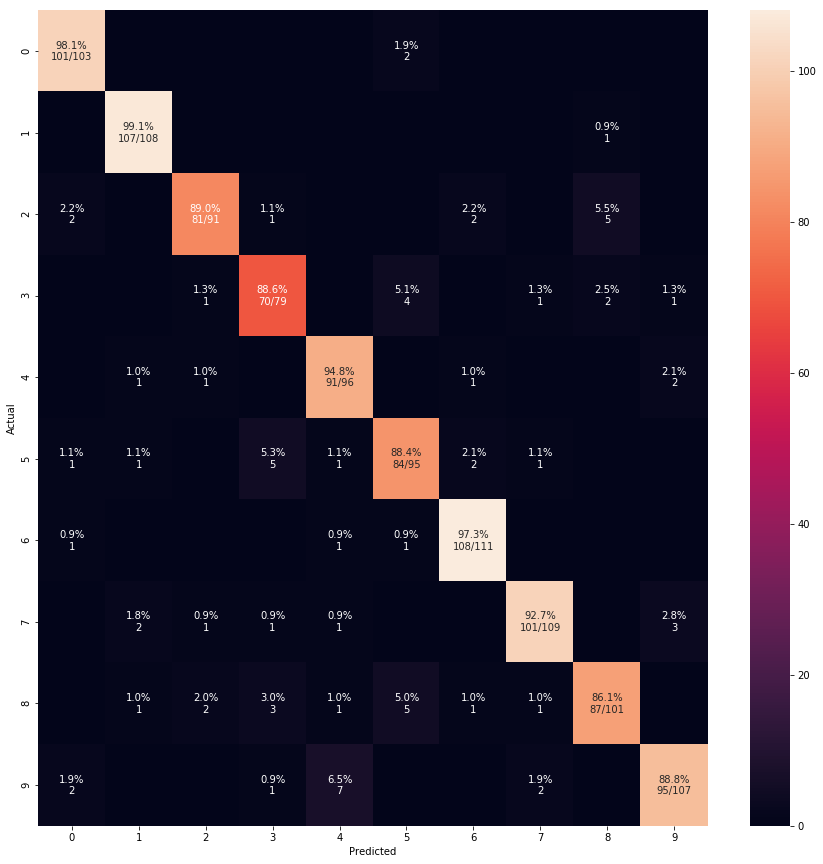

In [9]:
cm_analysis(y_test, clf.predict(X_test), range(10))

In [10]:
# Training time
import time

clf = SVC(kernel='linear', C=0.01,probability=True,random_state=seed)
start_time = time.time()
clf.fit(X_train, y_train)
print("Time taken for training %s seconds" % (time.time() - start_time))


start_time = time.time()
pred = clf.predict(X_train)
print("Time taken for inference %s seconds" % (time.time() - start_time))

Time taken for training 18.6786460876 seconds
Time taken for inference 5.55156612396 seconds
